In [1]:
import os
import torch
from torchtools.utils import plot_batch

from train_autoprotonet import get_dataset, get_model
from vis_prototypes import get_prototypes, get_support_query_data_labels_model, generate_prototype_img_using_adam

In [2]:
ckpt_dir = '/vulcanscratch/psando/checkpoints-meta/workshop_paper_checkpoints/mi-autoprotonet-5w5s'

test_way = 5
val_shot = 5
val_query = 5
val_episode = 2000
episodes_per_batch = 1

class Options(object):
    def __init__(self, dataset, network, test_way, val_shot, val_query, head='ProtoNet'):
        self.dataset = dataset
        self.network = network
        self.head = head
        self.activation = 'LeakyReLU'
        self.test_way = test_way
        self.val_shot = val_shot
        self.val_query = val_query
        self.episodes_per_batch = episodes_per_batch
opt = Options(dataset=('CIFAR_FS' if 'cifarfs' in ckpt_dir else 'miniImageNet'), network=('AutoProtoNet' if 'autoprotonet' in ckpt_dir else 'ProtoNet'), test_way=test_way, val_shot=val_shot, val_query=val_query)

In [14]:
data_support, labels_support, data_query, labels_query, embedding_net, cls_head = get_support_query_data_labels_model(opt, epoch=2)

Loading mini ImageNet dataset - phase train
Loading mini ImageNet dataset - phase val


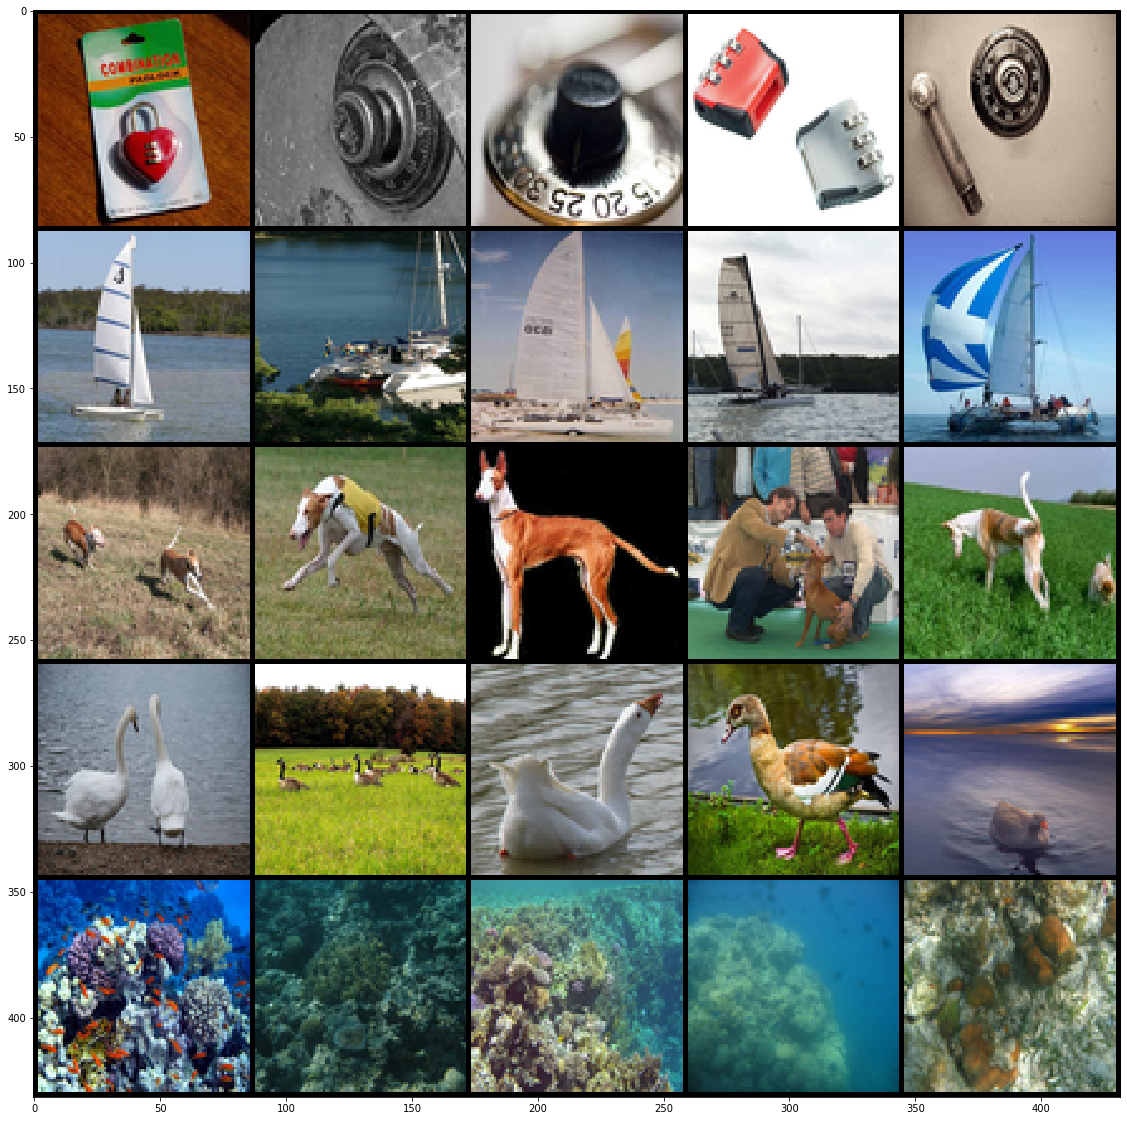

In [15]:
labels_support = labels_support.squeeze()
sort_support_indices = torch.argsort(labels_support)

plot_batch(data_support[sort_support_indices].cpu(), figsize=(20,20), nrow=test_way)

In [16]:
ckpt = torch.load(os.path.join(ckpt_dir, 'best_model.pth'))
cls_head.load_state_dict(ckpt['head'], strict=True)
embedding_net.load_state_dict(ckpt['embedding'], strict=True)

<All keys matched successfully>

In [17]:
with torch.no_grad():
    emb_query = embedding_net(data_query)
    emb_support = embedding_net(data_support)
    print('emb query shape', emb_query.shape)
    print('emb support shape', emb_support.shape)
    train_n_support = test_way * val_shot
    train_n_query = test_way * val_query
    emb_query = emb_query.reshape(episodes_per_batch, train_n_query, -1)
    emb_support = emb_support.reshape(episodes_per_batch, train_n_support, -1)
    print('emb query shape reshaped', emb_query.shape)
    print('emb support shape reshaped', emb_support.shape)
    prototypes = get_prototypes(emb_query, emb_support, labels_support, test_way, val_shot)
    print('prototypes shape', prototypes.shape)

emb query shape torch.Size([25, 1600])
emb support shape torch.Size([25, 1600])
emb query shape reshaped torch.Size([1, 25, 1600])
emb support shape reshaped torch.Size([1, 25, 1600])
prototypes shape torch.Size([1, 5, 1600])


In [18]:
proto_imgs_adam = generate_prototype_img_using_adam(embedding_net, prototypes.squeeze(dim=0), img_size=(32 if opt.dataset == 'CIFAR_FS' else 84), 
                                                    lr=0.01,
                                                    max_steps=20000)

[Step 0] Last LR: 0.01 L2 norm: 105.42826080322266
[Step 500] Last LR: 0.01 L2 norm: 7.458543300628662
[Step 1000] Last LR: 0.01 L2 norm: 6.112377166748047
[Step 1500] Last LR: 0.01 L2 norm: 5.362598419189453
[Step 2000] Last LR: 0.01 L2 norm: 4.7128753662109375
[Step 2500] Last LR: 0.01 L2 norm: 4.315342903137207
[Step 3000] Last LR: 0.01 L2 norm: 4.076245307922363
[Step 3500] Last LR: 0.01 L2 norm: 3.891758441925049
[Step 4000] Last LR: 0.01 L2 norm: 3.7172131538391113
[Step 4500] Last LR: 0.01 L2 norm: 3.790799617767334
[Step 5000] Last LR: 0.01 L2 norm: 3.362989664077759
[Step 5500] Last LR: 0.01 L2 norm: 3.4483389854431152
[Step 6000] Last LR: 0.01 L2 norm: 3.2065625190734863
[Step 6500] Last LR: 0.01 L2 norm: 3.2702622413635254
[Step 7000] Last LR: 0.01 L2 norm: 3.2229666709899902
[Step 7500] Last LR: 0.01 L2 norm: 3.1838700771331787
[Step 8000] Last LR: 0.01 L2 norm: 3.137970447540283
[Step 8500] Last LR: 0.01 L2 norm: 2.989710807800293
[Step 9000] Last LR: 0.01 L2 norm: 2.88842

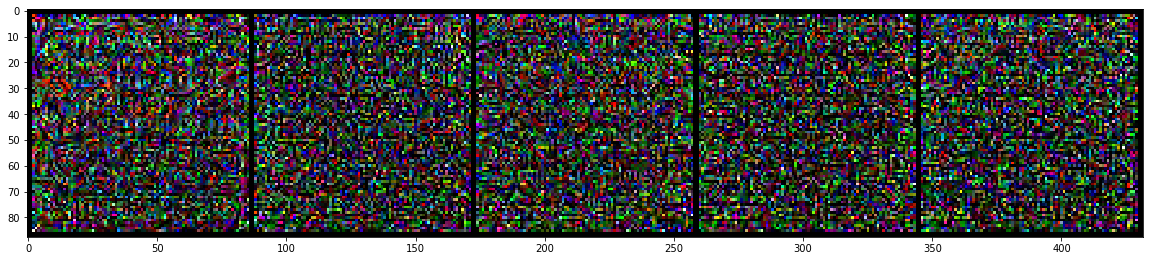

In [19]:
plot_batch(proto_imgs_adam.cpu(), figsize=(20,20))

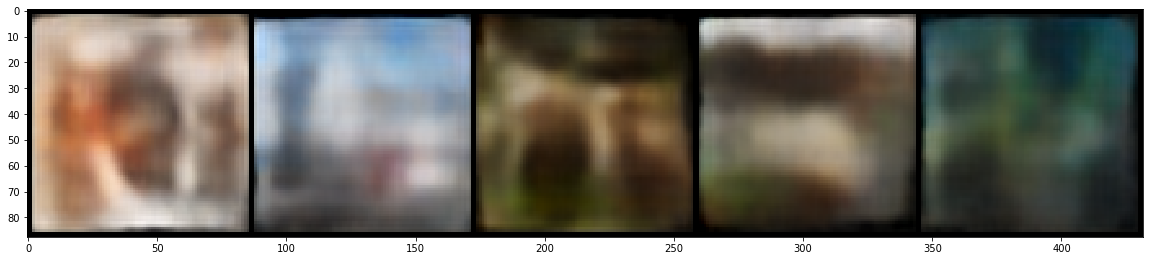

In [20]:
# Plot decoder reconstructions of adam optimized images
proto_imgs_decoder = embedding_net.forward_plus_decoder(proto_imgs_adam)
plot_batch(proto_imgs_decoder.cpu(), figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


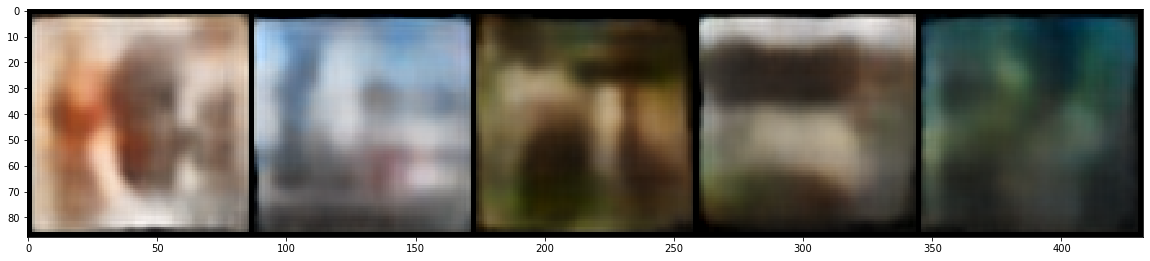

In [21]:
# Plot decoder reconstructions of prototypes
plot_batch(embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))

In [11]:
# Plot decoder reconstructions of support data
# plot_batch(embedding_net.forward_decoder(emb_support.reshape(embedding_net.embedding_shape))[sort_support_indices].cpu(), figsize=(20,20), nrow=val_shot)

In [12]:
# Plot query data
# labels_query = labels_query.squeeze()
# sort_query_indices = torch.argsort(labels_query)
# plot_batch(data_query[sort_query_indices].cpu(), figsize=(20,20), nrow=val_shot)

In [13]:
# Plot decoder reconstructions of query data
# plot_batch(embedding_net.forward_decoder(emb_query.reshape(embedding_net.embedding_shape))[sort_query_indices].cpu(), figsize=(20,20), nrow=val_shot)